# Test JulES

### Import packages

In [1]:
using Pkg; Pkg.status()
Pkg.add("CSV"); Pkg.add("Revise"); Pkg.add("Plots"); Pkg.add("PlotlyJS"); Pkg.add("PrettyTables") # package not in JulES environment
# Pkg.update("TuLiPa") # uncomment to update TuLiPa to latest version
# Pkg.develop(path=joinpath(dirname(dirname(pwd())),"TuLiPa")); Pkg.status() # go to development version
# Pkg.undo(); Pkg.status() # go back to main package version
# Pkg.add(url="https://github.com/NVE/TuLiPa.git"); Pkg.status() # alternative go back to latest version

In [2]:
using DataFrames, Statistics, JSON, Distributed, Clustering, YAML, CSV, Plots, PrettyTables, Revise
# plotlyjs(); #uncomment for interactive plots

In [3]:
config = YAML.load_file(joinpath("data", "config_jules_vassdrag.yml"))
scenarioyear = config["main"]["weatheryears"][1]
datayear = config["main"]["datayears"][1]

2021

### Prepare parallell processing - import code on all cores

In [4]:
const numcores = config["main"]["numcores"]

if nprocs() < numcores
    addprocs(numcores - nprocs())
end

@show nprocs();

nprocs() = 1


In [5]:
@everywhere using TuLiPa, Dates
# @everywhere include(joinpath(dirname(dirname(dirname(pwd()))),"jgrc/TuLiPa/src/TuLiPa.jl"));

In [6]:
@everywhere using JulES
# @everywhere include(joinpath(dirname(pwd()),"src/JulES.jl"));

In [7]:
function getdataset(config, scenarioyear)
    # Read watercourse, elspot area and price series
    watercourse = config["data"]["watercourse"]
    elspotnames = config["data"]["elspotnames"] # some watercourses are in several elspot areas
    priceseriesname = config["data"]["priceseriesname"] 

    # Read hydropower dataelements from json-files
    sti_dynmodelldata = joinpath(config["main"]["inputpath"], "dataset_vassdrag")
    tidsserie = JSON.parsefile(joinpath(sti_dynmodelldata,"tidsserier_detd.json"))
    detdseries = getelements(tidsserie, sti_dynmodelldata);
    dst = JSON.parsefile(joinpath(sti_dynmodelldata, "dataset_detd_" * watercourse * ".json"))
    detdstructure = getelements(dst);
    elements = vcat(detdseries,detdstructure)

    # Add an exogenous price area that the plants and pumps can interact with. All units are in NO5.
    for elspotname in elspotnames
        addexogenbalance!(elements, "PowerBalance_" * elspotname, "Power", "AreaPrice")
    end

    # Add dataelements for price in exogen area
    price_path = joinpath(config["main"]["inputpath"], config["data"]["price"])
    df = CSV.read(price_path, DataFrame; header=3, decimal=',', types=Float64)
    df[:,"aar"] = cld.(1:first(size(df)), 2912) .+ 1957
    df[:,"tsnitt"] = rem.(0:(first(size(df))-1), 2912) .+ 1
    df.datetime .= getisoyearstart.(Int.(df.aar)) + Hour.((df.tsnitt.-1)*3) # TODO: Include week 53. Now ignored and flat prices.
    push!(elements, DataElement(TIMEINDEX_CONCEPT,"VectorTimeIndex","AreaPriceProfileIndex",
            Dict("Vector" => df.datetime)))
    push!(elements, DataElement(TIMEVALUES_CONCEPT,"VectorTimeValues","AreaPriceProfileValues",
            Dict("Vector" => df[:,priceseriesname])))
    push!(elements, getelement(TIMEVECTOR_CONCEPT,"RotatingTimeVector","AreaProfile",
            (TIMEINDEX_CONCEPT,"AreaPriceProfileIndex"),(TIMEVALUES_CONCEPT,"AreaPriceProfileValues")))
    addparam!(elements, "MeanSeriesParam", "AreaPrice", 1.0, "AreaProfile")

    return Dict("elements" => elements, "detailedrescopl" => Dict())
end

dataset = getdataset(config, scenarioyear)

Dict{String, Any} with 2 entries:
  "elements"        => DataElement[DataElement("TimeDelta", "MsTimeDelta", "Day…
  "detailedrescopl" => Dict{Any, Any}()

In [8]:
data = JulES.run_serial(config, datayear, scenarioyear, dataset)

Time parameters
  0.030200 seconds (1.38 k allocations: 91.345 KiB, 99.33% compilation time)
Get data
  0.000038 seconds (9 allocations: 656 bytes)


Make dummy objects
  0.826355 seconds (496.12 k allocations: 32.835 MiB, 97.46% compilation time)
Init scenario modelling for simulation, prognosis and stochastic


  3.269534 seconds (519.51 k allocations: 27.680 MiB, 99.96% compilation time)
  3.326954 seconds (531.01 k allocations: 28.445 MiB, 99.95% compilation time)
Init stochastic


  0.249269 seconds (219.67 k allocations: 14.007 MiB, 94.93% compilation time)


  5.364230 seconds (3.00 M allocations: 200.540 MiB, 3.16% gc time, 98.71% compilation time)
  0.077013 seconds (46.33 k allocations: 3.145 MiB, 99.71% compilation time)


  7.443515 seconds (4.06 M allocations: 269.446 MiB, 2.28% gc time, 98.76% compilation time: <1% of which was recompilation)
Init results


  1.351410 seconds (541.38 k allocations: 36.412 MiB, 99.78% compilation time)


Simulate forward
FixedDataTwoTime(

DateTime("2021-01-04T00:00:00"), DateTime("1980-12-31T00:00:00"))


  0.853729 seconds (454.63 k allocations: 27.760 MiB, 6.69% gc time, 97.84% compilation time)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-01-02T00:00:00"))
  0.016814 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-01-04T00:00:00"))
  0.016073 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-01-06T00:00:00"))
  0.015847 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-01-08T00:00:00"))
  0.014920 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-01-10T00:00:00"))


  0.025922 seconds (59.53 k allocations: 1.699 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-01-12T00:00:00"))
  0.014840 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-01-14T00:00:00"))
  0.015745 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-01-16T00:00:00"))
  0.015151 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-01-18T00:00:00"))
  0.015102 seconds (59.51 k allocations: 1.695 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-01-20T00:00:00"))
  0.025994 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-01-22T00:00:00"))


  0.029674 seconds (59.53 k allocations: 1.700 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-01-24T00:00:00"))
  0.017332 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-01-26T00:00:00"))
  0.016733 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-01-28T00:00:00"))
  0.017603 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-01-30T00:00:00"))


  0.016664 seconds (59.53 k allocations: 1.697 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-02-01T00:00:00"))
  0.015349 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-02-03T00:00:00"))
  0.017306 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-02-05T00:00:00"))
  0.016869 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-02-07T00:00:00"))
  0.016320 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-02-09T00:00:00"))
  0.025688 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-02-11T00:00:00"))


  0.026743 seconds (59.53 k allocations: 1.700 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-02-13T00:00:00"))
  0.015737 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-02-15T00:00:00"))
  0.028501 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-02-17T00:00:00"))
  0.015876 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-02-19T00:00:00"))
  0.015414 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-02-21T00:00:00")

)
  0.026033 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-02-23T00:00:00"))
  0.015525 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-02-25T00:00:00"))
  0.015593 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-02-27T00:00:00"))
  0.015712 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-03-01T00:00:00"))


  0.016223 seconds (59.53 k allocations: 1.697 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-03-03T00:00:00"))
  0.016386 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-03-05T00:00:00"))
  0.015861 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-03-07T00:00:00"))
  0.026985 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-03-09T00:00:00"))


  0.027069 seconds (59.53 k allocations: 1.697 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-03-11T00:00:00"))
  0.016016 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-03-13T00:00:00"))


  0.104022 seconds (61.46 k allocations: 1.826 MiB, 60.49% gc time, 11.42% compilation time)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-03-15T00:00:00"))
  0.016866 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-03-17T00:00:00"))
  0.015631 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-03-19T00:00:00"))
  0.015277 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-03-21T00:00:00"))


  0.015562 seconds (59.53 k allocations: 1.697 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-03-23T00:00:00"))
  0.015197 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-03-25T00:00:00"))
  0.015209 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-03-27T00:00:00"))
  0.014963 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-03-29T00:00:00"))
  0.026007 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-03-31T00:00:00"))


  0.026087 seconds (59.53 k allocations: 1.699 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-04-02T00:00:00"))
  0.026648 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-04-04T00:00:00"))
  0.015785 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-04-06T00:00:00"))
  0.015330 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-04-08T00:00:00"))


  0.015118 seconds (59.53 k allocations: 1.697 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-04-10T00:00:00"))
  0.025845 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-04-12T00:00:00"))
  0.026020 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-04-14T00:00:00"))


  0.015586 seconds (59.54 k allocations: 1.697 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-04-16T00:00:00"))
  0.015792 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-04-18T00:00:00"))
  0.015971 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-04-20T00:00:00"))
  0.025898 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-04-22T00:00:00"))


  0.026479 seconds (59.54 k allocations: 1.698 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-04-24T00:00:00"))
  0.026419 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-04-26T00:00:00"))
  0.015830 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-04-28T00:00:00"))
  0.015805 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-04-30T00:00:00"))


  0.026505 seconds (59.53 k allocations: 1.697 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-05-02T00:00:00"))
  0.015954 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-05-04T00:00:00"))
  0.015675 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-05-06T00:00:00"))
  0.026160 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-05-08T00:00:00")

)
  0.016726 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-05-10T00:00:00"))
  0.016873 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-05-12T00:00:00"))
  0.016889 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-05-14T00:00:00"))
  0.026187 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-05-16T00:00:00"))


  0.016688 seconds (59.53 k allocations: 1.697 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-05-18T00:00:00"))
  0.017901 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-05-20T00:00:00"))
  0.016715 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-05-22T00:00:00"))
  0.017346 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-05-24T00:00:00"))


  0.027272 seconds (59.53 k allocations: 1.697 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-05-26T00:00:00"))
  0.016288 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-05-28T00:00:00"))
  0.016046 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-05-30T00:00:00"))
  0.015927 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-06-01T00:00:00"))
  0.026242 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-06-03T00:00:00"))


  0.072032 seconds (59.58 k allocations: 1.709 MiB, 75.33% gc time)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-06-05T00:00:00"))
  0.018036 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-06-07T00:00:00"))
  0.016122 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-06-09T00:00:00"))
  0.015581 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-06-11T00:00:00"))
  0.014854 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-06-13T00:00:00"))
  0.016026 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-06-15T00:00:00"))


  0.015724 seconds (59.53 k allocations: 1.700 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-06-17T00:00:00"))
  0.015137 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-06-19T00:00:00"))
  0.015069 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-06-21T00:00:00"))
  0.015070 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-06-23T00:00:00"))
  0.014803 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-06-25T00:00:00"))
  0.014246 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-06-27T00:00:00"))


  0.026401 seconds (59.53 k allocations: 1.700 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-06-29T00:00:00"))
  0.015120 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-07-01T00:00:00"))
  0.025865 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-07-03T00:00:00"))
  0.016789 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-07-05T00:00:00"))


  0.027499 seconds (59.54 k allocations: 1.697 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-07-07T00:00:00"))
  0.016003 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-07-09T00:00:00"))
  0.025500 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime

("2021-01-04T00:00:00"), DateTime("1981-07-11T00:00:00"))
  0.026234 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-07-13T00:00:00"))
  0.015114 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-07-15T00:00:00"))
  0.026332 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-07-17T00:00:00"))


  0.016328 seconds (59.53 k allocations: 1.697 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-07-19T00:00:00"))
  0.015481 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-07-21T00:00:00"))
  0.015310 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-07-23T00:00:00"))
  0.014252 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-07-25T00:00:00"))
  0.026941 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-07-27T00:00:00"))


  0.026693 seconds (59.53 k allocations: 1.700 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-07-29T00:00:00"))
  0.015738 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-07-31T00:00:00"))
  0.015394 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-08-02T00:00:00"))
  0.026348 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-08-04T00:00:00"))


  0.016004 seconds (59.54 k allocations: 1.697 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-08-06T00:00:00"))
  0.015649 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-08-08T00:00:00"))
  0.016511 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-08-10T00:00:00"))
  0.016246 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-08-12T00:00:00"))
  0.015265 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-08-14T00:00:00"))
  0.015007 seconds (59.50 k allocations: 1.693 MiB)


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-08-16T00:00:00"))
  0.016158 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-08-18T00:00:00"))
  0.016301 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-08-20T00:00:00"))
  0.015478 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-08-22T00:00:00"))
  0.015469 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-08-24T00:00:00"))


  0.014277 seconds (59.29 k allocations: 1.691 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-08-26T00:00:00"))
  0.060992 seconds (59.50 k allocations: 1.692 MiB, 55.26% gc time)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-08-28T00:00:00"))
  0.015667 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-08-30T00:00:00"))


  0.015808 seconds (59.53 k allocations: 1.697 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-09-01T00:00:00"))
  0.026086 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-09-03T00:00:00"))
  0.026500 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-09-05T00:00:00"))
  0.015858 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-09-07T00:00:00"))


  0.025853 seconds (59.54 k allocations: 1.697 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-09-09T00:00:00"))
  0.026271 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-09-11T00:00:00"))
  0.015569 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-09-13T00:00:00"))
  0.015366 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-09-15T00:00:00"))


  0.026985 seconds (59.53 k allocations: 1.697 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-09-17T00:00:00"))
  0.015591 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-09-19T00:00:00"))
  0.016527 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-09-21T00:00:00"))
  0.015579 seconds (59.50 k allocations: 1.693 MiB)


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-09-23T00:00:00"))
  0.015302 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-09-25T00:00:00"))
  0.015089 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-09-27T00:00:00"))
  0.027129 seconds (59.50 k allocations: 1.692 MiB)


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-09-29T00:00:00"))
  0.017091 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-10-01T00:00:00"))
  0.015556 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-10-03T00:00:00"))
  0.016053 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-10-05T00:00:00"))
  0.015232 seconds (59.50 k allocations: 1.693 MiB)


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-10-07T00:00:00"))
  0.016025 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-10-09T00:00:00"))
  0.013901 seconds (59.26 k allocations: 1.685 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-10-11T00:00:00"))
  0.016973 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-10-13T00:00:00"))


  0.015994 seconds (59.53 k allocations: 1.697 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-10-15T00:00:00"))
  0.015047 seconds (59.26 k allocations: 1.685 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-10-17T00:00:00"))
  0.016671 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-10-19T00:00:00"))
  0.026320 seconds (59.50 k allocations: 1.692 MiB)


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-10-21T00:00:00"))
  0.015850 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-10-23T00:00:00"))
  0.016137 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-10-25T00:00:00"))
  0.027233 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-10-27T00:00:00"))
  0.017079 seconds (59.50 k allocations: 1.692 MiB)


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-10-29T00:00:00"))
  0.016884 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-10-31T00:00:00"))
  0.017240 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-11-02T00:00:00"))
  0.016165 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-11-04T00:00:00"))
  0.016183 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-11-06T00:00:00"))


  0.016584 seconds (59.53 k allocations: 1.699 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-11-08T00:00:00"))
  0.016890 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-11-10T00:00:00"))
  0.015860 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-11-12T00:00:00"))
  0.015976 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-11-14T00:00:00"))


  0.027979 seconds (59.53 k allocations: 1.697 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-11-16T00:00:00"))
  0.014664 seconds (59.26 k allocations: 1.685 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-11-18T00:00:00"))
  0.046652 seconds (59.50 k allocations: 1.692 MiB, 63.50% gc time)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-11-20T00:00:00"))
  0.015785 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-11-22T00:00:00"))
  0.017441 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-11-24T00:00:00"))


  0.015745 seconds (59.53 k allocations: 1.699 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-11-26T00:00:00"))
  0.015142 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-11-28T00:00:00"))
  0.016016 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-11-30T00:00:00"))
  0.025200 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-12-02T00:00:00"))
  0.015063 seconds (59.50 k allocations: 1.693 MiB)


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-12-04T00:00:00"))
  0.015274 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-12-06T00:00:00"))
  0.025960 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-12-08T00:00:00"))
  0.015474 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-12-10T00:00:00"))


  0.025702 seconds (59.53 k allocations: 1.697 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-12-12T00:00:00"))
  0.026384 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-12-14T00:00:00"))
  0.026122 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-12-16T00:00:00"))


  0.016244 seconds (59.53 k allocations: 1.697 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-12-18T00:00:00"))
  0.015727 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-12-20T00:00:00"))
  0.015959 seconds (59.50 k allocations: 1.693 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-12-22T00:00:00"))
  0.026731 seconds (59.50 k allocations: 1.692 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-12-24T00:00:00"))


  0.015183 seconds (59.53 k allocations: 1.697 MiB)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-12-26T00:00:00"))
  0.027571 seconds (59.50 k allocations: 1.692 MiB)
The simulation took: 0.11528901333333333 minutes
Time usage per timestep: 0.03800736703296703 seconds
Handle output

Row,umaster,usub,conv,count,smaster,ssub,hlmaster,wwres,total,short,core
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Bool,Int64
1,7.4926e-5,0.00581046,0.0106349,1.9779,0.000621519,0.00962491,0.000177177,3.74635e-5,0.0177248,false,1


Row,core,umaster_sum,usub_sum,conv_sum,count_sum,smaster_sum,ssub_sum,hlmaster_sum,wwres_sum,total_sum
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,7.4926e-5,0.00581046,0.0106349,1.9779,0.000621519,0.00962491,0.000177177,3.74635e-5,0.0177248


9-element Vector{Float64}:
 7.492596685082872e-5
 0.0058104552486187835
 0.010634885635359118
 1.977900552486188
 0.0006215187845303867
 0.009624907182320442
 0.00017717734806629832
 3.746353591160221e-5
 0.017724814364640882

 10.272940 seconds (9.64 M allocations: 630.325 MiB, 4.01% gc time, 99.59% compilation time: 6% of which was recompilation)


Dict{Any, Any} with 25 entries:
  "svindex"            => [DateTime("1980-12-29T00:00:00"), DateTime("1980-12-3…
  "demandbalancenames" => SubString{String}[]
  "skipfactor"         => 1.0
  "stochastictimes"    => [0.0001195 0.0050799 … 6.21e-5 0.163151; 9.03e-5 0.00…
  "resindex"           => [DateTime("1980-12-29T00:00:00"), DateTime("1980-12-3…
  "areanames"          => ["NO4"]
  "priceindex"         => [DateTime("1980-12-29T00:00:00"), DateTime("1980-12-3…
  "batmatrix"          => Matrix{Float64}(undef, 364, 0)
  "stateindex"         => [DateTime("1980-12-29T00:00:00"), DateTime("1980-12-3…
  "statematrix"        => [8.0 9.0 … 8.0 3506.0; 8.0 9.0 … 8.0 3506.0; … ; 0.02…
  "statenames"         => ["Reservoir_67301", "Reservoir_67306_max", "Reservoir…
  "resnames"           => ["Reservoir_67306", "Reservoir_67301", "Reservoir_673…
  "shorts"             => Bool[0, 0, 0]
  "demandvalues"       => Matrix{Float64}(undef, 364, 0)
  "batindex"           => [DateTime("1980-12-29T00:00:00

In [9]:
powerbalancenames = data["areanames"]
prices = data["pricematrix"]
x1 = data["priceindex"]

hydronames = data["resnames"]
hydrolevels = data["resmatrix"]
x2 = data["resindex"]

batterynames = data["batnames"]
batterylevels = data["batmatrix"]
x2 = data["batindex"]

statenames = data["statenames"]
statematrix = data["statematrix"]
x3 = data["stateindex"]

supplyvalues = data["supplyvalues"]
supplynames = data["supplynames"]
supplybalancenames = data["supplybalancenames"]

demandvalues = data["demandvalues"]
demandnames = data["demandnames"]
demandbalancenames = data["demandbalancenames"];

storagevalues = data["storagevalues"]
storagenames = data["storagenames"]
scenarionames = data["scenarionames"];

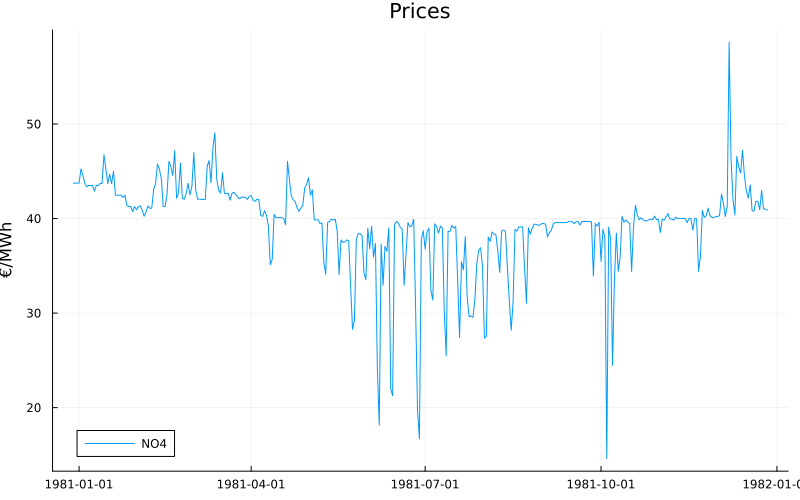

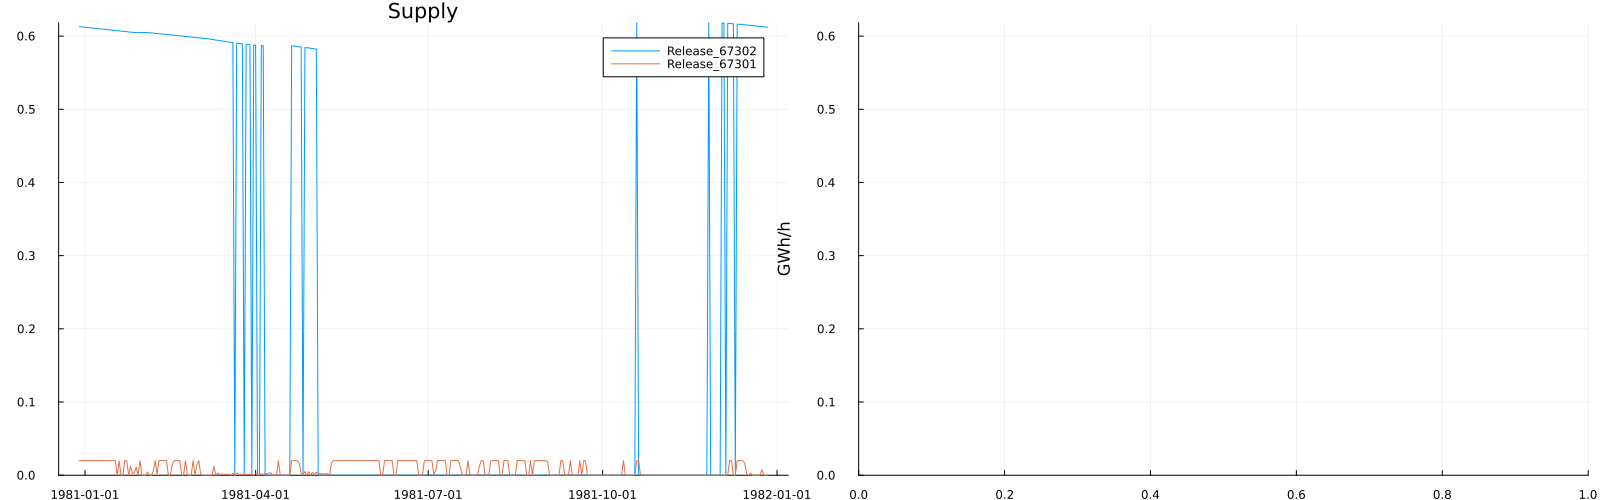

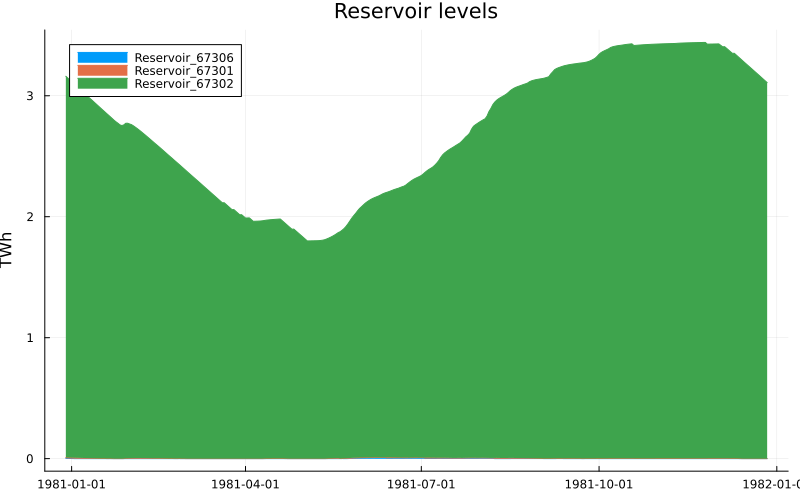

┌───────────────┬───────────────────┬────────────┬───────────────────┐
│    Supplyname │ Yearly_supply_TWh │ Demandname │ Yearly_demand_TWh │
├───────────────┼───────────────────┼────────────┼───────────────────┤
│ Release_67302 │           1.89849 │    missing │           missing │
│ Release_67301 │         0.0721795 │    missing │           missing │
└───────────────┴───────────────────┴────────────┴───────────────────┘


┌───────────────────────────────────┬───────────────────────────────────┐
│ Yearly_supply_TWh_sum_skipmissing │ Yearly_demand_TWh_sum_skipmissing │
├───────────────────────────────────┼───────────────────────────────────┤
│                           1.97067 │                               0.0 │
└───────────────────────────────────┴───────────────────────────────────┘


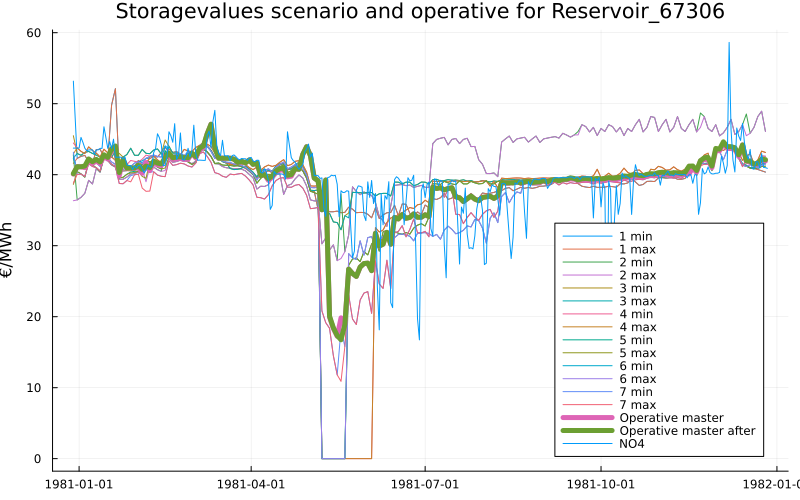

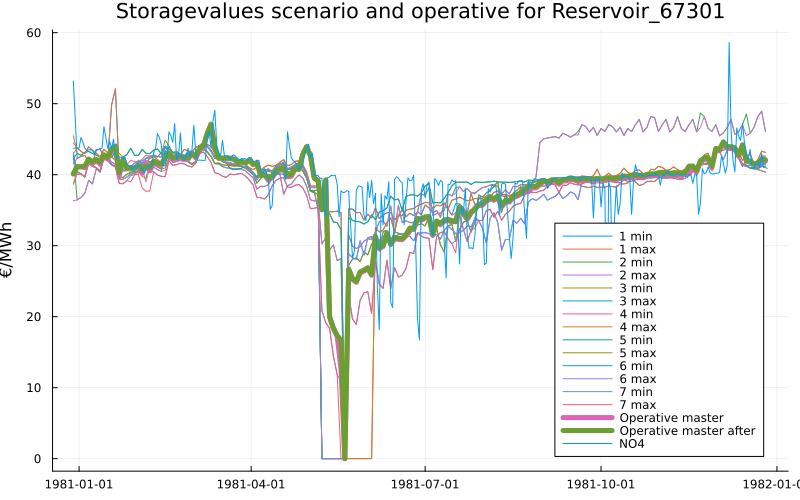

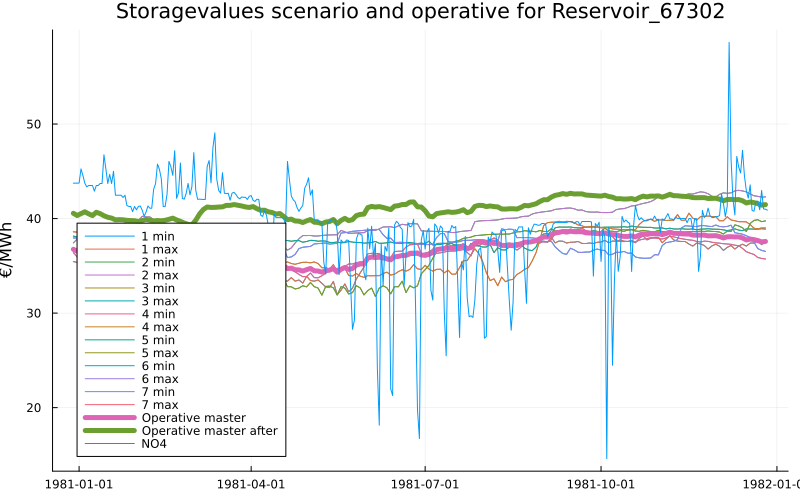

┌───────────────┬──────────────────┬────────────┬───────────────────┐
│    Supplyname │ Yearly_rev_mill€ │ Demandname │ Yearly_cost_mill€ │
├───────────────┼──────────────────┼────────────┼───────────────────┤
│ Release_67302 │          82.0024 │    missing │           missing │
│ Release_67301 │          2.92034 │    missing │           missing │
└───────────────┴──────────────────┴────────────┴───────────────────┘
┌──────────────────────────────────┬───────────────────────────────────┐
│ Yearly_rev_mill€_sum_skipmissing │ Yearly_cost_mill€_sum_skipmissing │
├──────────────────────────────────┼───────────────────────────────────┤
│                          84.9228 │                               0.0 │
└──────────────────────────────────┴───────────────────────────────────┘


In [10]:
# Plot prices
display(plot(x1, prices, labels=reshape(powerbalancenames,1,length(powerbalancenames)), size=(800,500), title="Prices", ylabel="€/MWh"))

# # Plot supplies and demands
maxdemsup = isempty(supplyvalues) ? maximum(demandvalues) : (isempty(demandvalues) ? maximum(supplyvalues) : max(maximum(demandvalues), maximum(supplyvalues)))
supplychart = plot(x1, supplyvalues,labels=reshape(supplynames,1,length(supplynames)),title="Supply", ylabel = "GWh/h", ylims=(0,maxdemsup))
demandchart = plot(x1, demandvalues,labels=reshape(demandnames,1,length(demandnames)),title="Demand", ylabel = "GWh/h", ylims=(0,maxdemsup))
display(plot([supplychart,demandchart]...,layout=(1,2),size=(1600,500)))

# Plot storages
display(areaplot(x2, hydrolevels,labels=reshape(hydronames,1,length(hydronames)),size=(800,500),title="Reservoir levels", ylabel = "TWh")) #
# display(areaplot(x2, dropdims(sum(hydrolevels,dims=2),dims=2),labels="Total reservoirs",size=(800,500),title="Reservoir levels", ylabel = "Gm3")) #

# Plot list of yearly mean production and demand for each supply/demand
meandemand = dropdims(mean(demandvalues,dims=1),dims=1)
meanproduction = dropdims(mean(supplyvalues,dims=1),dims=1)
supplydf = sort(DataFrame(Supplyname = supplynames, Yearly_supply_TWh = meanproduction*8.76),[:Yearly_supply_TWh], rev = true)
demanddf = sort(DataFrame(Demandname = demandnames, Yearly_demand_TWh = meandemand*8.76),[:Yearly_demand_TWh], rev = true)
supplydf[!,:ID] = collect(1:length(supplynames))
demanddf[!,:ID] = collect(1:length(demandnames))
joineddf = select!(outerjoin(supplydf,demanddf;on=:ID),Not(:ID))
pretty_table(joineddf, show_subheader=false)

# Check that total supply equals total demand
pretty_table(combine(joineddf, [:Yearly_supply_TWh, :Yearly_demand_TWh] .=> sum∘skipmissing), show_subheader=false)

# Plot list of yearly income and cost for each supply/demand
supplyrev = copy(supplyvalues)
for (i,supplybalancename) in enumerate(supplybalancenames)
    idx = findfirst(isequal(supplybalancename), powerbalancenames)
    supplyrev[:,i] .= supplyrev[:,i] .* prices[:,idx]
end
demandrev = copy(demandvalues)
for (i,demandbalancename) in enumerate(demandbalancenames)
    idx = findfirst(isequal(demandbalancename), powerbalancenames)
    demandrev[:,i] .= demandrev[:,i] .* prices[:,idx]
end
meandemandrev = dropdims(mean(demandrev,dims=1),dims=1)
meanproductionrev = dropdims(mean(supplyrev,dims=1),dims=1)
supplyrevdf = sort(DataFrame(Supplyname = supplynames, Yearly_rev_mill€ = meanproductionrev*8.76),[:Yearly_rev_mill€], rev = true)
demandrevdf = sort(DataFrame(Demandname = demandnames, Yearly_cost_mill€ = meandemandrev*8.76),[:Yearly_cost_mill€], rev = true)
supplyrevdf[!,:ID] = collect(1:length(supplynames))
demandrevdf[!,:ID] = collect(1:length(demandnames))
joinedrevdf = select!(outerjoin(supplyrevdf,demandrevdf;on=:ID),Not(:ID))
pretty_table(joinedrevdf, show_subheader=false)

# Sum revenues and cost
pretty_table(combine(joinedrevdf, [:Yearly_rev_mill€, :Yearly_cost_mill€] .=> sum∘skipmissing), show_subheader=false)

# Plot storagevalues for each reservoir and scenarios
numop = length(findall(sn -> occursin("Operative", sn), scenarionames))
numscen = length(scenarionames) - numop
for (i, storagename) in enumerate(storagenames)
    p = plot(x3, storagevalues[:,1:numscen,i] / -1, size=(800,500), title="Storagevalues scenario and operative for " * storagename, labels=reshape(scenarionames[1:numscen], 1, numscen), ylabel="€/MWh")
    plot!(p, x3, storagevalues[:,numscen+1:end,i] / -1, labels=reshape(scenarionames[numscen+1:end], 1, numop), linewidth=5)
    plot!(p, x1, prices, labels=powerbalancenames[1])
    display(p)
 end